# Grand X-Ray Slam Division A: Transfer learning with ResNet-50

This notebook shows how to apply [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) with ResNet-50 to diagnose the X-ray images of the competition.

References
- Competition: [Grand X-Ray Slam: Division A](https://www.kaggle.com/competitions/grand-xray-slam-division-a)
- The ResNet paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385)
- [ResNet-50 API documentation](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import threading

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.calibration import CalibrationDisplay

import cv2
import os

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.metrics import AUC
import tensorflow.keras.applications.resnet50 as resnet50

2025-08-30 17:06:59.443747: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756573619.664619      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756573619.727592      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def plot_training_history(history):
    """Plot a Keras training history."""
    if len(history['loss']) >= 2:
        _, axs = plt.subplots(2, 1, figsize=(6, 6))
        axs[0].plot(history['loss'], ':', label='train_loss')
        axs[0].plot(history['val_loss'], label='val_loss')
        axs[0].legend()
        axs[1].plot(history['AUC'], ':', label='train_auc')
        axs[1].plot(history['val_AUC'], label='val_auc')
        axs[1].legend()
        plt.tight_layout()
        plt.suptitle('Training history', y=1)
        plt.show()


In [3]:
def evaluate_oof(y_train, oof_pred, baseline_true=None, baseline_oof_pred=None, label='', plot=True):
    """Compute oof scores and visualize them"""
    n_targets = y_train.shape[1]
    n_horizontal = (n_targets + 1) // 2 # diagrams per row
    
    # Process y_train and oof_pred
    if type(oof_pred) is not pd.DataFrame:
        oof_pred = pd.DataFrame(oof_pred, columns=y_train.columns)
    assert y_train.shape == oof_pred.shape, (y_train.shape, oof_pred.shape)
    valid_scores = np.ones(n_targets, dtype=bool)
    scores = np.full(n_targets, 0.5)
    for i, target in enumerate(y_train.columns):
        try:
            scores[i] = roc_auc_score(y_train[target], oof_pred[target])
        except ValueError:
            scores[i] = np.nan
            valid_scores[i] = False
    macro_mean = np.nanmean(scores[:14])

    # Process baseline_true and baseline_oof_pred
    if baseline_oof_pred is not None and type(baseline_oof_pred) is not pd.DataFrame:
        baseline_oof_pred = pd.DataFrame(baseline_oof_pred, columns=y_train.columns)
        assert baseline_true.shape == baseline_oof_pred.shape, (baseline_true.shape, baseline_oof_pred.shape) 
        baseline_scores = np.array(roc_auc_score(baseline_true, baseline_oof_pred, average=None))

    # Print
    print(f"{label}\t{macro_mean:.3f}", end='')
    for i in range(len(scores)):
        print(f"\t{scores[i]:.3f}", end='')
    print()

    if plot:
        # Bar chart
        plt.figure(figsize=(16, 3))
        plt.title(f"Average AUC: {macro_mean:.3f} ({label})")
        if baseline_oof_pred is not None:
            baseline_to_plot = np.where(valid_scores, baseline_scores, np.nan)
            plt.bar(np.arange(len(scores)) - 0.2, baseline_to_plot - 0.5, bottom=0.5, width=0.4, color='lightgray')
            bars = plt.bar(np.arange(len(scores)) + 0.2, scores - 0.5, bottom=0.5, width=0.4, color='darkgreen')
        else:
            bars = plt.bar(np.arange(len(scores)), scores - 0.5, bottom=0.5, width=0.8, color='lightgray')
        plt.bar_label(bars, fmt='%.3f')
        if n_targets > 14:
            plt.axvline(13.5, color='gray')
        plt.xticks(np.arange(len(scores)), y_train.columns, rotation=45, ha='right')
        plt.ylim(0.5, 1)
        plt.show()
    
        # ROC curves
        _, axs = plt.subplots(2, n_horizontal, figsize=(14, 4))
        for i, (target, ax) in enumerate(zip(y_train.columns, axs.ravel())):
            if valid_scores[i]:
                RocCurveDisplay.from_predictions(y_train[target], oof_pred[target], ax=ax)
                ax.get_legend().remove()
                ax.set_title(target)
                ax.set_xlabel(None) # false positive rate
                ax.set_ylabel(None) # true positive rate
                ax.set_aspect('equal')
            else:
                ax.set_visible(False)
        if n_targets < len(axs.ravel()):
            axs[-1, -1].set_visible(False)
        plt.tight_layout()
        plt.suptitle('Receiver operating curves', y=1)
        plt.show()
    
        # Histograms
        _, axs = plt.subplots(2, n_horizontal, figsize=(14, 3))
        for i, (target, ax) in enumerate(zip(y_train.columns, axs.ravel())):
            if valid_scores[i]:
                ax.hist(oof_pred[target], bins=np.linspace(0, 1, 100), color='brown', density=True)
                ax.set_title(target)
                ax.set_xlabel(None) # predicted probability
                ax.set_ylabel(None) # density
            else:
                ax.set_visible(False)
        if n_targets < len(axs.ravel()):
            axs[-1, -1].set_visible(False)
    
        plt.tight_layout()
        plt.suptitle('Predicted probability histograms', y=1.01)
        plt.show()

        # Calibration curves
        _, axs = plt.subplots(2, n_horizontal, figsize=(14, 4))
        for i, (target, ax) in enumerate(zip(y_train.columns, axs.ravel())):
            if valid_scores[i]:
                CalibrationDisplay.from_predictions(y_train[target], oof_pred[target], 
                                                    ax=ax, color='g',
                                                    n_bins=10, strategy='quantile')
                ax.get_legend().remove()
                ax.set_title(target)
                ax.set_xlabel(None) # predicted probability
                ax.set_ylabel(None) # true probability
                ax.set_aspect('equal')
            else:
                ax.set_visible(False)
        if n_targets < len(axs.ravel()):
            axs[-1, -1].set_visible(False)
    
        plt.tight_layout()
        plt.suptitle('Calibration display', y=1)
        plt.show()


# Reading the metadata

We read the metadata into the following dataframes:
- `train`: image names and features for the training dataset
- `y_train`: binary targets (ground truth)
- `test`: image names and features for the test dataset

In [4]:
train = pd.read_csv('/kaggle/input/grand-xray-slam-division-a/train1.csv')
test = pd.read_csv('/kaggle/input/grand-xray-slam-division-a/sample_submission_1.csv')[['Image_name']]
targets = list(train.columns[-14:])

print("Targets:", targets)

y_train = train[targets].copy()

# Just for fun, we add three more targets:
y_train['male'] = np.where(train.Sex == 'Male', 1, 0) # must be binary classification
y_train['female'] = np.where(train.Sex == 'Female', 1, 0) # must be binary classification
y_train['frontal'] = (train.ViewCategory == 'Frontal').astype(float)

def engineer_features(df):
    df['Patient_ID'] = df['Image_name'].str.slice(0, 8).astype(int)
    df['Study'] = df['Image_name'].str.slice(9, 12).astype(int)
    df['Patient_Study'] = df['Image_name'].str.slice(0, 12).astype(int)
    df['institute'] = df['Patient_ID'] // 10000000
    return df

engineer_features(train)
engineer_features(test)
display(test.tail(4))


Targets: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


,Image_name,Patient_ID,Study,Patient_Study,institute
46229,20009236_000_000.jpg,20009236,0,20009236000,2
46230,20009238_000_000.jpg,20009238,0,20009238000,2
46231,20009240_000_000.jpg,20009240,0,20009240000,2
46232,20009241_000_000.jpg,20009241,0,20009241000,2


In [5]:
# # Test the notebook with a subset of the data
# train = train.iloc[:1000]
# y_train = y_train.iloc[:1000]
# test = test.iloc[:60]


# Preprocessing

Data preprocessing is tha part of the notebook which takes the most time. We read 200 GByte of images from an NFS server, resize them, and feed them through a 50-layer neural network. Fortunately we don't need to train the 50-layer ResNet ourselves: The model has been pretrained on other images. 

This is the essence of transfer learning: Somebody else has trained the model with some other images, and we transfer the network's learned weights to our own application (diagnosing X-ray images). ResNet-50 computes a 2048-feature vector (an embedding) for every image, and we only train a small classifier (the "head") on these features. 

ResNet-50 is an ordinary Keras model. You can print its summary with `resnet50_model.summary()`.

We save the preprocessing results (i.e., the embeddings of all images) to disk so that in the next version of the notebook we can skip preprocessing. If you copy the notebook, you can save some time by simply reading the two files from the output of this public notebook.

In [6]:
# %%time
n_threads = 10 # set to 1 for debugging, 10 for production
width = 224 # must be divisible by 32
height = 224 # must be divisible by 32
resnet_embedding_dim = 2048

def load_and_resize_images(n_threads, j, paths, images, width, height):
    """Load and resize a subset of the images.

    This function is to be executed by several threads in parallel.

    The images are resized to width x height pixels. If the original image
    isn't square, the pixels are stretched.
    """
    for im_idx in range(j, len(paths), n_threads):
        img = cv2.imread(paths[im_idx], cv2.IMREAD_GRAYSCALE)
        assert img is not None
        img = cv2.resize(img, (width, height)) # resize expects (width, height)
        # if n_threads == 1 and im_idx < 10:
        #     print(img.shape, img.dtype) # array has shape (height, width) and dtype uint8
        #     plt.imshow(img, vmin=0, vmax=255)
        #     plt.show()
        images[im_idx] = img


def load_and_resize_dataset(directory, df, width, height):
    """Load and resize all images of a dataset.
    
    The images are read by several threads in parallel: Reading the images is i/o-bound, and
    multithreading gives good speedup. Unfortunately, multithreading is incompatible with tqdm.
    The process can take an hour, and you won't see a progress bar.
    """
    assert width % 32 == 0, 'must be divisible by 32' 
    assert height % 32 == 0, 'must be divisible by 32'
    image_dir = f'/kaggle/input/grand-xray-slam-division-a/{directory}/'
    paths = [f'/kaggle/input/grand-xray-slam-division-a/{directory}/{p}' for p in df.Image_name]
    print(f"{directory}: Processing {len(df)} images")

    # Create an array of resized images of shape (n_images, height, width) and dtype uint8
    images = np.zeros((len(df), height, width), dtype=np.uint8)

    if n_threads > 1:
        threads = [threading.Thread(target=load_and_resize_images, args=(n_threads, j, paths, images, width, height)) for j in range(n_threads)]
        for thread in threads: thread.start()
        for thread in threads: thread.join()
    else: # debug in the main thread
        load_and_resize_images(1, 0, paths, images, width, height)

    assert (images.sum(axis=2).sum(axis=1) != 0).all()
    return images

    
def embed_with_ResNet(images):
    """Read the uint8 array of images and compute embeddings"""

    embeddings = np.zeros((len(images), resnet_embedding_dim), dtype=np.float32)
    batch_size = 10240
    for batch_start in trange(0, len(images), batch_size):
        
        # Convert grayscale to rgb and center
        # X = img_train # shape (n_samples, HEIGHT, WIDTH) of uint8
        Xb = images[batch_start:batch_start+batch_size]
        XX = np.repeat(Xb, 3).reshape(Xb.shape + (3, )) # shape (n_samples, HEIGHT, WIDTH, 3)
        XX = resnet50.preprocess_input(XX)
        
        # Compute embeddings
        embeddings[batch_start:batch_start+batch_size] = resnet50_model.predict(XX, batch_size=256, verbose=1) # shape (n_samples, 2048)
    return embeddings


def load_resize_embed(directory, df, width, height):
    images = load_and_resize_dataset(directory, df, width, height)
    embeddings = embed_with_ResNet(images)
    print(f"embeddings_{directory[:-1]}.shape = {embeddings.shape}")
    
    embeddings.tofile(f"embeddings_{directory[:-1]}.binary")
    loading = f"np.memmap(f'embeddings_{directory[:-1]}.binary', mode='r', dtype=np.float32, shape={embeddings.shape})"
    embeddings_2 = eval(loading)
    assert (embeddings == embeddings_2).all()
    print(f"Next time, you can load the embeddings with\n\n    embeddings_{directory[:-1]} = {loading}\n")

    return embeddings


# Load the ResNet50 model
resnet50_model = resnet50.ResNet50(include_top=False,
                               weights='imagenet',
                               pooling='avg',
                               input_shape=(height, width, 3))

# Print the model summary
# resnet50_model.summary()

# Do the job
embeddings_train = load_resize_embed('train1', train, width, height)
embeddings_test = load_resize_embed('test1', test, width, height)


2025-08-30 17:07:13.449553: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
train1: Processing 107374 images


  0%|          | 0/11 [00:00<?, ?it/s]

40/40 ━━━━━━━━━━━━━━━━━━━━ 837s 21s/step


  9%|▉         | 1/11 [14:25<2:24:13, 865.33s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 833s 21s/step


 18%|█▊        | 2/11 [28:44<2:09:16, 861.88s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 826s 21s/step


 27%|██▋       | 3/11 [42:56<1:54:17, 857.22s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 842s 21s/step


 36%|███▋      | 4/11 [57:19<1:40:15, 859.39s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 826s 21s/step


 45%|████▌     | 5/11 [1:11:29<1:25:35, 855.98s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 819s 20s/step


 55%|█████▍    | 6/11 [1:25:30<1:10:54, 850.99s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 834s 21s/step


 64%|██████▎   | 7/11 [1:39:43<56:47, 851.78s/it]  

40/40 ━━━━━━━━━━━━━━━━━━━━ 819s 20s/step


 73%|███████▎  | 8/11 [1:53:46<42:27, 849.03s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 824s 21s/step


 82%|████████▏ | 9/11 [2:07:52<28:15, 847.88s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 815s 20s/step


 91%|█████████ | 10/11 [2:21:49<14:04, 844.72s/it]

20/20 ━━━━━━━━━━━━━━━━━━━━ 412s 21s/step


100%|██████████| 11/11 [2:28:50<00:00, 811.90s/it]


embeddings_train.shape = (107374, 2048)
Next time, you can load the embeddings with

    embeddings_train = np.memmap(f'embeddings_train.binary', mode='r', dtype=np.float32, shape=(107374, 2048))

test1: Processing 46233 images


  0%|          | 0/5 [00:00<?, ?it/s]

40/40 ━━━━━━━━━━━━━━━━━━━━ 864s 22s/step


 20%|██        | 1/5 [14:56<59:47, 896.94s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 839s 21s/step


 40%|████      | 2/5 [29:23<43:56, 878.98s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 836s 21s/step


 60%|██████    | 3/5 [43:41<28:58, 869.30s/it]

40/40 ━━━━━━━━━━━━━━━━━━━━ 828s 21s/step


 80%|████████  | 4/5 [57:54<14:22, 862.82s/it]

21/21 ━━━━━━━━━━━━━━━━━━━━ 438s 21s/step


100%|██████████| 5/5 [1:05:24<00:00, 784.84s/it]


embeddings_test.shape = (46233, 2048)
Next time, you can load the embeddings with

    embeddings_test = np.memmap(f'embeddings_test.binary', mode='r', dtype=np.float32, shape=(46233, 2048))



# The Keras PyDataset

This class reads the embeddings and returns them in batches together with the metadata.

In [7]:
# Custom data generator for images

class XRayGeneratorForResNet(Sequence):
    """Sequence of image batches.

    The images are read from disk with fixed width and height. It is possible that
    pixels are no longer square after the transformation.

    X and y have the same index; this index corresponds to the positions of the images in the array.
    """
    def __init__(self, X, y=None, embeddings=None, shuffle=False, batch_size=32):
        super().__init__(workers=1)
        assert embeddings is not None
        if y is not None:
            assert len(X) == len(y)
        self.X = X # dataframe with columns 'Image_name' and 'institute'
        self.y = y # dataframe with one column per target
        self.embeddings = embeddings
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Shuffle to avoid all images in a batch being of the same patient
        self.permutation = np.arange(len(self.X))
        if self.shuffle:
            self.rng = np.random.default_rng(1)
            self.rng.shuffle(self.permutation)

    def __len__(self):
        """Number of batches in one epoch, including a smaller batch at the end."""
        return (len(self.X) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        """Return a batch of images (and optionally, labels).

        Returns
        images: float32 array of shape (batch_size, resnet_embedding_dim)
        metadata: float32 array of shape (batch_size, 1)
        labels: float32 array of shape (batch_size, n_targets)
        """
        start_idx = idx * self.batch_size
        end_idx = min(start_idx + self.batch_size, len(self.X))
        batch_indexes = self.permutation[start_idx:end_idx]
        resnet_embeddings = self.embeddings[self.X.index[batch_indexes]]
        metadata = self.X[['institute']].values[batch_indexes].astype(np.float32)
        features = {'resnet_embeddings': resnet_embeddings, 'metadata': metadata}

        if self.y is not None:
            labels = self.y.values[batch_indexes].astype(np.float32)
            return features, labels
        return features


# The model

We use a fully connected model with two hidden layers as our classifier. It takes the embeddings and some metadata as input, and it predicts probabilities for all classes.

In [8]:
def create_head_model(num_classes=y_train.shape[1]):
    resnet_embeddings = Input((resnet_embedding_dim, ), name='resnet_embeddings')
    metadata =  Input((1, ), name='metadata')
    x = Concatenate()([resnet_embeddings, metadata])
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(num_classes, activation='sigmoid')(x)
    model = Model(inputs={'resnet_embeddings': resnet_embeddings,
                          'metadata': metadata},
                  outputs=x,
                  name='Resnet50-Head')
    return model    

create_head_model().summary()


Model: "Resnet50-Head"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ resnet_embeddings   │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ metadata            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2049)      │          0 │ resnet_embedding… │
│ (Concatenate)       │                   │            │ metadata[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     65,664 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 17)        │      2,193 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,117,457 (4.26 MB)

 Trainable params: 1,117,457 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

# Model fitting and inference

We run a five-fold cross-validation of our model. Because the test patients are disjoint from the training patients, we use a GroupKFold.

To do:
1. Study the diagrams and find ideas to improve the model. Which target is the easiest to predict and which is the hardest?
2. Compare the cross-validation score to the leaderboard score. Do the scores match?

Fitting Resnet50-Head
Epoch 1/50
1343/1343 - 22s - 16ms/step - AUC: 0.8330 - loss: 0.3386 - val_AUC: 0.8650 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 2/50
1343/1343 - 18s - 13ms/step - AUC: 0.8543 - loss: 0.3105 - val_AUC: 0.8683 - val_loss: 0.3006 - learning_rate: 0.0010
Epoch 3/50
1343/1343 - 18s - 14ms/step - AUC: 0.8608 - loss: 0.3014 - val_AUC: 0.8728 - val_loss: 0.2929 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1343/1343 - 17s - 13ms/step - AUC: 0.8655 - loss: 0.2962 - val_AUC: 0.8741 - val_loss: 0.2929 - learning_rate: 0.0010
Epoch 5/50
1343/1343 - 17s - 13ms/step - AUC: 0.8746 - loss: 0.2844 - val_AUC: 0.8782 - val_loss: 0.2856 - learning_rate: 5.0000e-04
Epoch 6/50
1343/1343 - 17s - 13ms/step - AUC: 0.8771 - loss: 0.2812 - val_AUC: 0.8793 - val_loss: 0.2835 - learning_rate: 5.0000e-04
Epoch 7/50
1343/1343 - 17s - 13ms/step - AUC: 0.8788 - loss: 0.2787 - val_AUC: 0.8805 - val_loss: 0.2806 - learning_rat

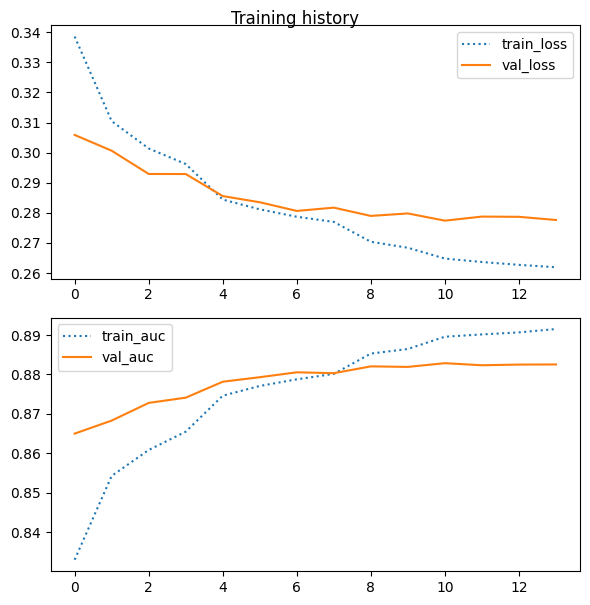


Validation
336/336 - 1s - 4ms/step
Resnet50-Head	0.883	0.893	0.918	0.917	0.907	0.964	0.895	0.763	0.899	0.889	0.879	0.826	0.856	0.809	0.942	0.982	0.981	1.000
Resnet50-Head grouped	0.886	0.896	0.920	0.920	0.909	0.965	0.899	0.768	0.903	0.893	0.883	0.832	0.861	0.815	0.944	0.983	0.982	1.000


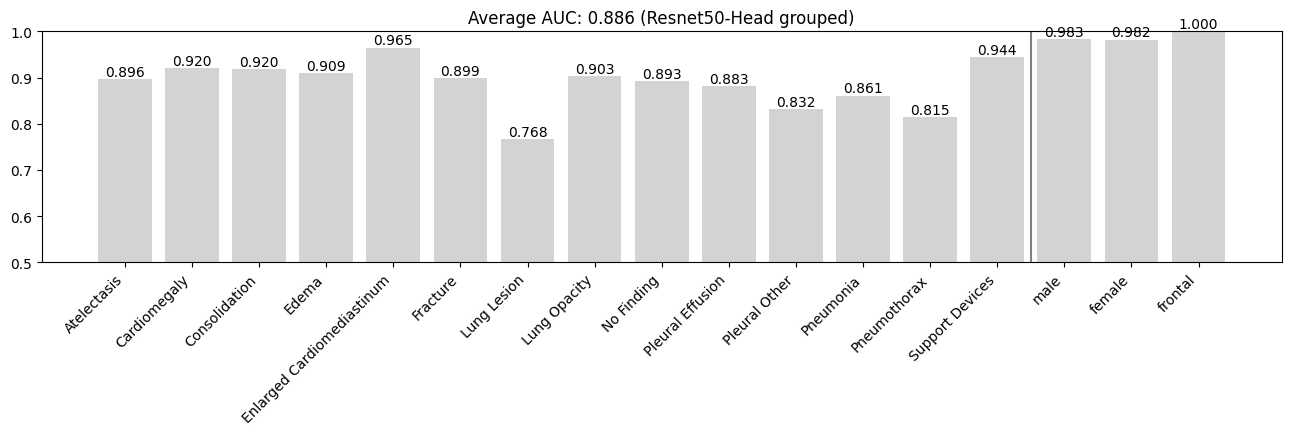

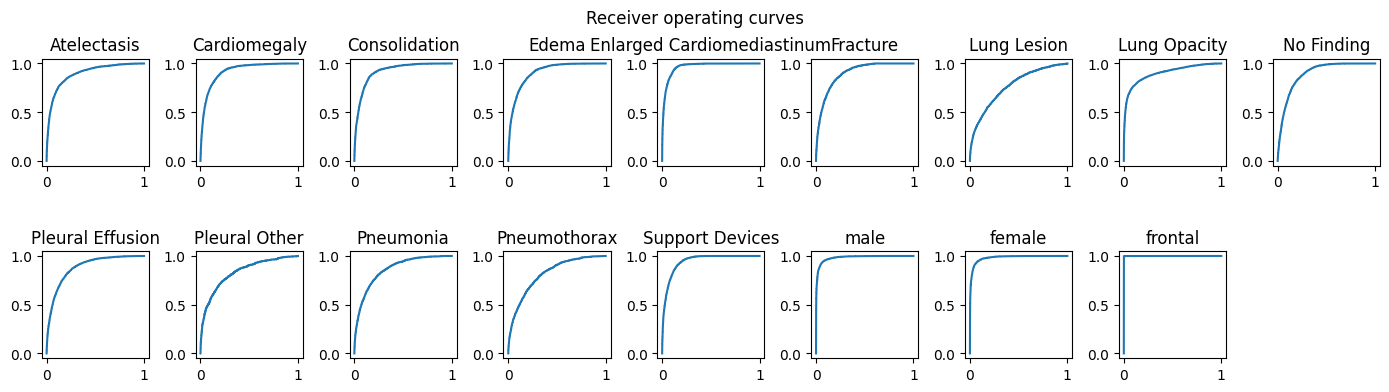

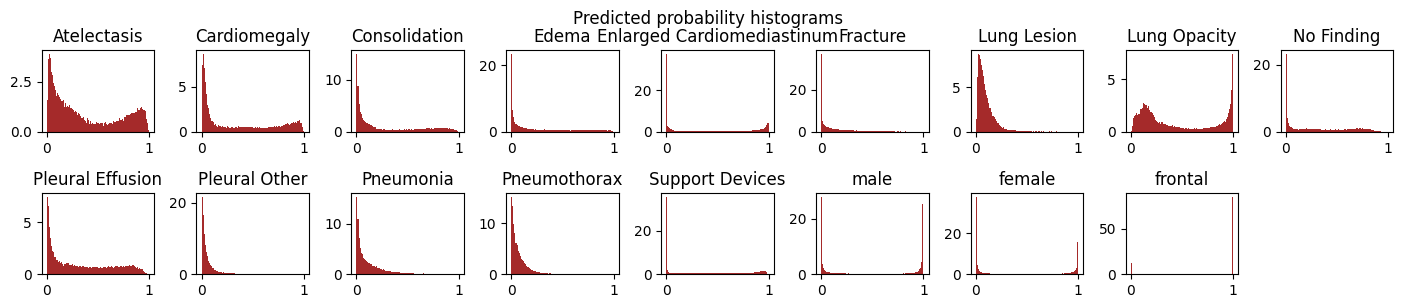

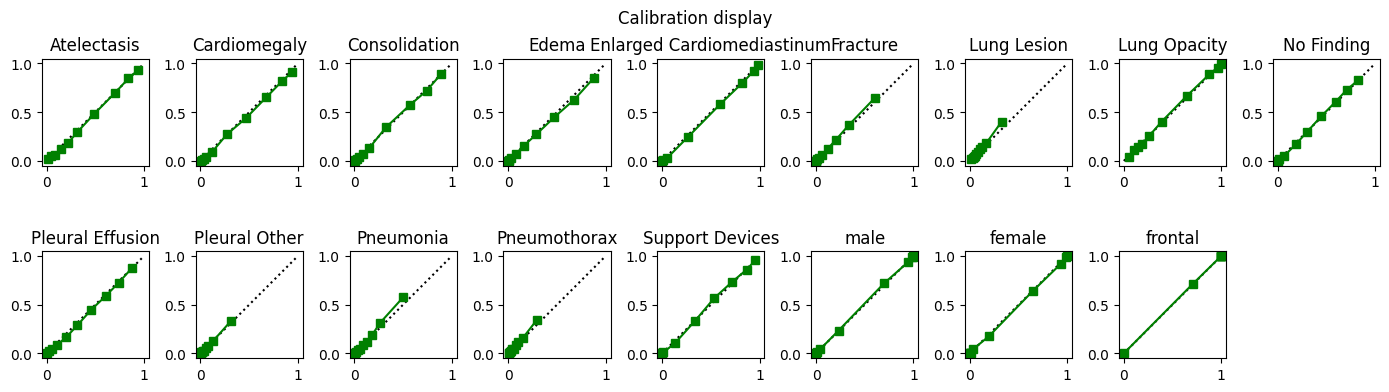


723/723 - 3s - 4ms/step
Fitting Resnet50-Head
Epoch 1/50
1343/1343 - 19s - 14ms/step - AUC: 0.8343 - loss: 0.3385 - val_AUC: 0.8575 - val_loss: 0.3095 - learning_rate: 0.0010
Epoch 2/50
1343/1343 - 16s - 12ms/step - AUC: 0.8559 - loss: 0.3102 - val_AUC: 0.8641 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 3/50
1343/1343 - 16s - 12ms/step - AUC: 0.8624 - loss: 0.3013 - val_AUC: 0.8674 - val_loss: 0.2926 - learning_rate: 0.0010
Epoch 4/50
1343/1343 - 16s - 12ms/step - AUC: 0.8674 - loss: 0.2953 - val_AUC: 0.8683 - val_loss: 0.2885 - learning_rate: 0.0010
Epoch 5/50

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1343/1343 - 17s - 12ms/step - AUC: 0.8697 - loss: 0.2917 - val_AUC: 0.8688 - val_loss: 0.2909 - learning_rate: 0.0010
Epoch 6/50
1343/1343 - 17s - 13ms/step - AUC: 0.8782 - loss: 0.2808 - val_AUC: 0.8752 - val_loss: 0.2816 - learning_rate: 5.0000e-04
Epoch 7/50
1343/1343 - 17s - 13ms/step - AUC: 0.8805 - loss: 0.2780 - val_AUC: 0.8752 - val_loss: 

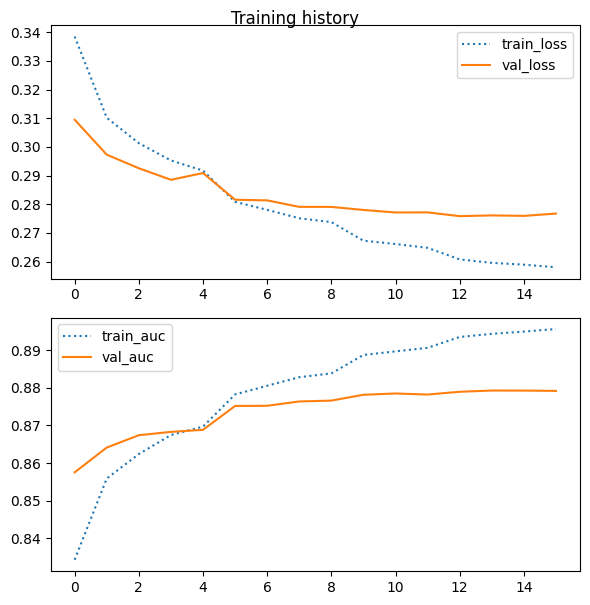


Validation
336/336 - 2s - 6ms/step
Resnet50-Head	0.879	0.884	0.923	0.920	0.918	0.965	0.890	0.750	0.896	0.884	0.874	0.833	0.842	0.789	0.942	0.982	0.980	1.000
Resnet50-Head grouped	0.883	0.888	0.925	0.923	0.921	0.967	0.894	0.755	0.899	0.888	0.878	0.839	0.846	0.794	0.944	0.983	0.981	1.000


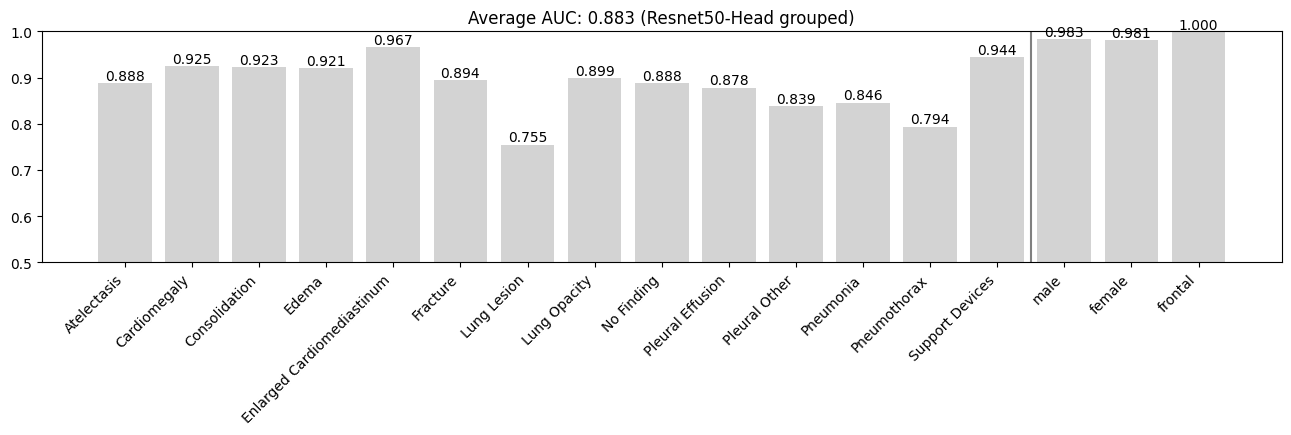

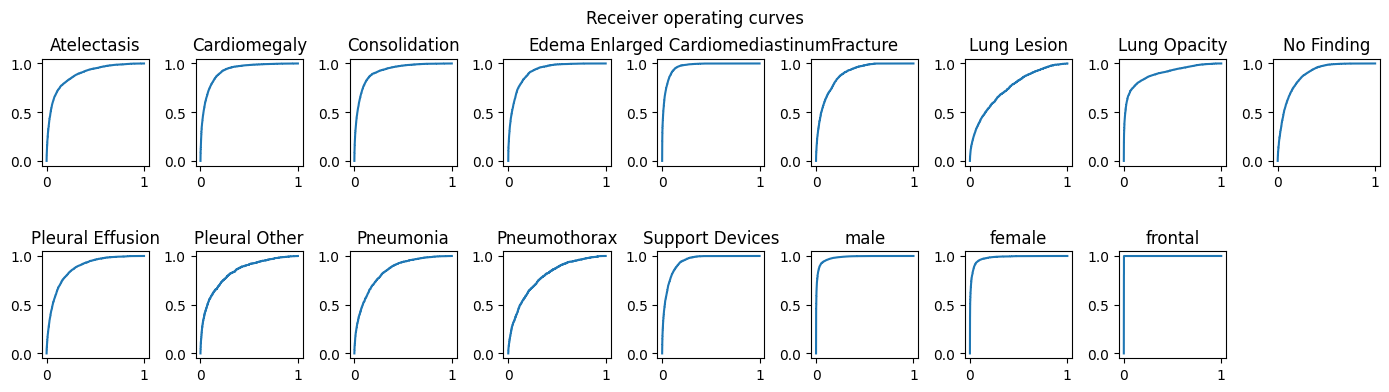

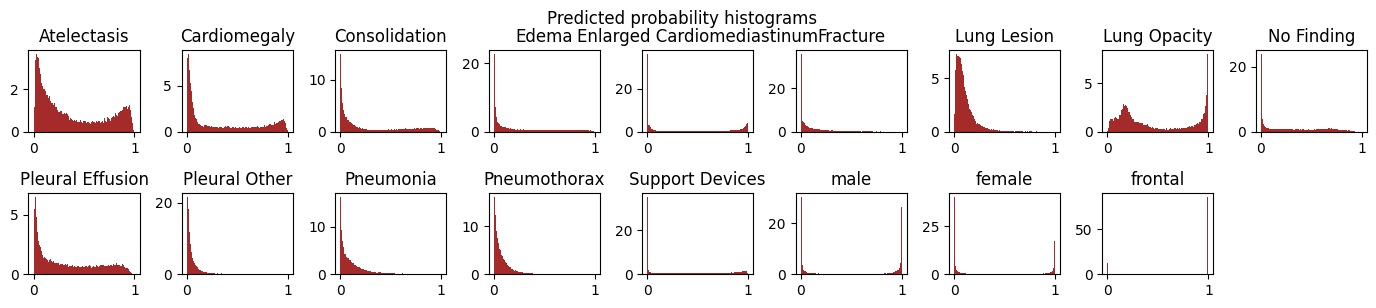

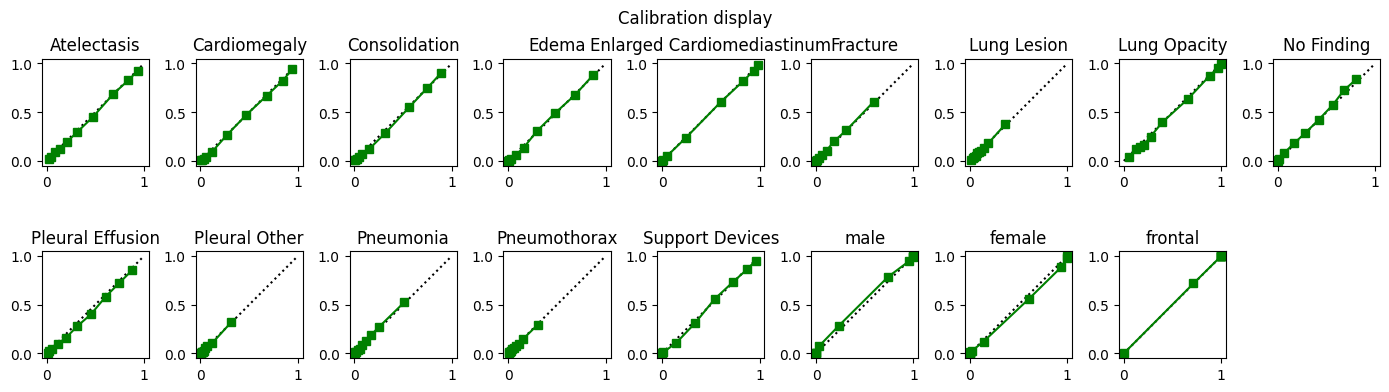


723/723 - 3s - 4ms/step
Fitting Resnet50-Head
Epoch 1/50
1343/1343 - 20s - 15ms/step - AUC: 0.8327 - loss: 0.3399 - val_AUC: 0.8613 - val_loss: 0.3057 - learning_rate: 0.0010
Epoch 2/50
1343/1343 - 17s - 13ms/step - AUC: 0.8538 - loss: 0.3116 - val_AUC: 0.8673 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 3/50
1343/1343 - 17s - 13ms/step - AUC: 0.8608 - loss: 0.3028 - val_AUC: 0.8724 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1343/1343 - 17s - 13ms/step - AUC: 0.8645 - loss: 0.2973 - val_AUC: 0.8727 - val_loss: 0.2922 - learning_rate: 0.0010
Epoch 5/50
1343/1343 - 17s - 13ms/step - AUC: 0.8737 - loss: 0.2858 - val_AUC: 0.8780 - val_loss: 0.2822 - learning_rate: 5.0000e-04
Epoch 6/50
1343/1343 - 17s - 13ms/step - AUC: 0.8761 - loss: 0.2824 - val_AUC: 0.8791 - val_loss: 0.2806 - learning_rate: 5.0000e-04
Epoch 7/50
1343/1343 - 17s - 12ms/step - AUC: 0.8782 - loss: 0.2800 - val_AUC: 0.8800 - val_lo

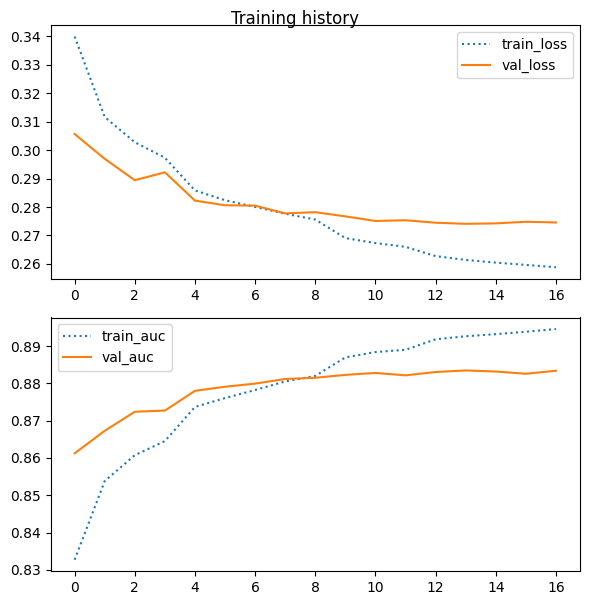


Validation
336/336 - 2s - 5ms/step
Resnet50-Head	0.883	0.889	0.922	0.917	0.915	0.967	0.901	0.766	0.897	0.889	0.878	0.831	0.847	0.808	0.941	0.981	0.980	1.000
Resnet50-Head grouped	0.887	0.892	0.925	0.920	0.918	0.968	0.904	0.772	0.899	0.894	0.882	0.838	0.852	0.813	0.943	0.982	0.981	1.000


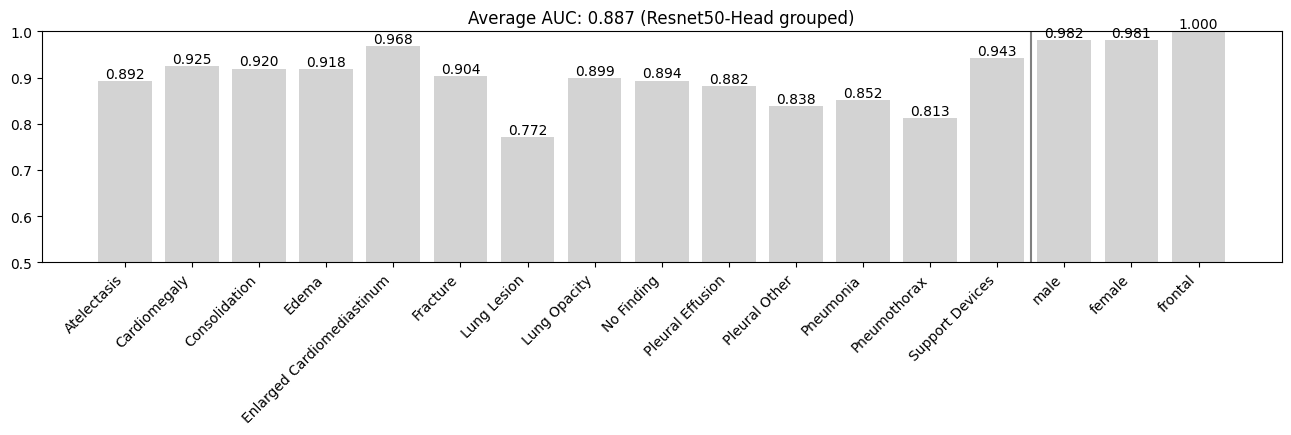

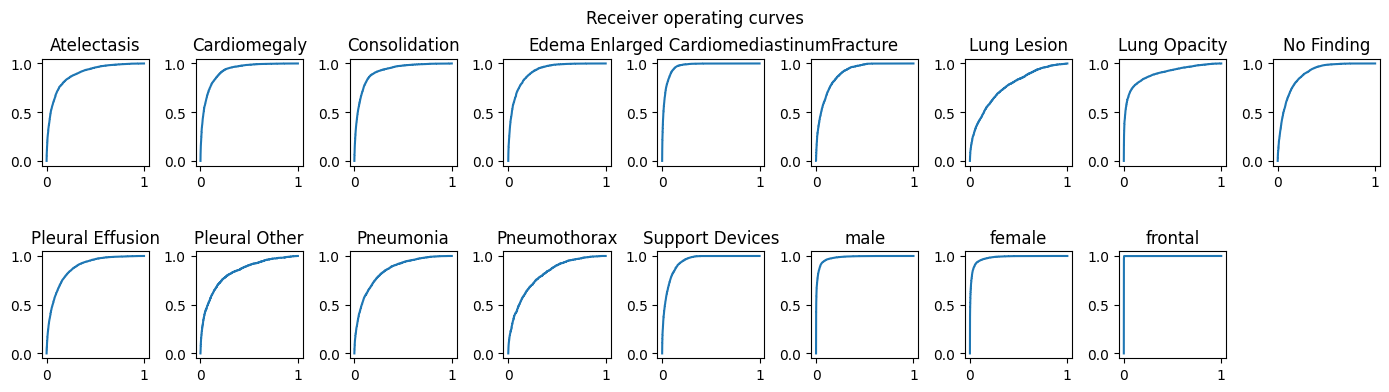

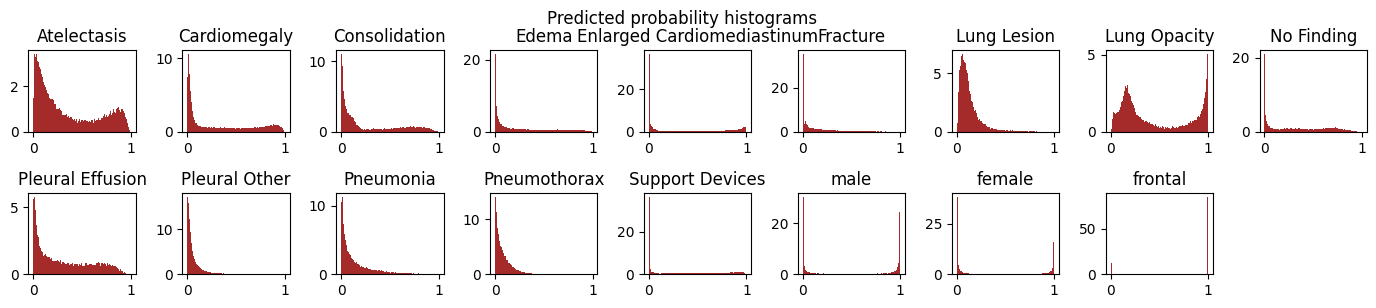

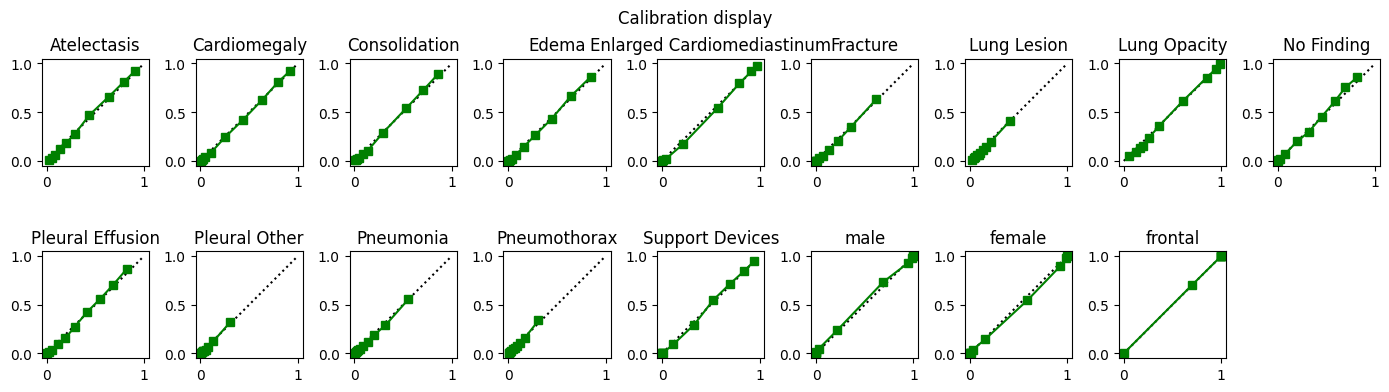


723/723 - 3s - 4ms/step
Fitting Resnet50-Head
Epoch 1/50
1343/1343 - 20s - 15ms/step - AUC: 0.8351 - loss: 0.3372 - val_AUC: 0.8631 - val_loss: 0.3064 - learning_rate: 0.0010
Epoch 2/50
1343/1343 - 17s - 13ms/step - AUC: 0.8564 - loss: 0.3082 - val_AUC: 0.8663 - val_loss: 0.3004 - learning_rate: 0.0010
Epoch 3/50
1343/1343 - 17s - 13ms/step - AUC: 0.8637 - loss: 0.2993 - val_AUC: 0.8712 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1343/1343 - 17s - 13ms/step - AUC: 0.8676 - loss: 0.2935 - val_AUC: 0.8713 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 5/50
1343/1343 - 17s - 13ms/step - AUC: 0.8766 - loss: 0.2821 - val_AUC: 0.8771 - val_loss: 0.2839 - learning_rate: 5.0000e-04
Epoch 6/50
1343/1343 - 17s - 13ms/step - AUC: 0.8786 - loss: 0.2789 - val_AUC: 0.8780 - val_loss: 0.2826 - learning_rate: 5.0000e-04
Epoch 7/50
1343/1343 - 17s - 13ms/step - AUC: 0.8812 - loss: 0.2762 - val_AUC: 0.8783 - val_lo

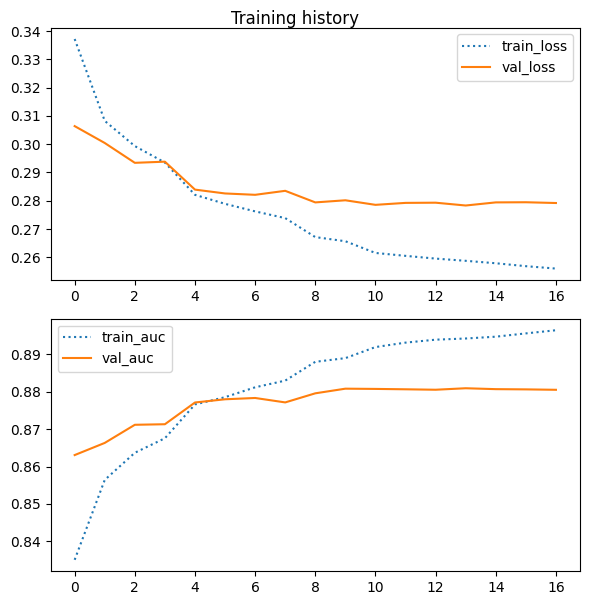


Validation
336/336 - 1s - 4ms/step
Resnet50-Head	0.881	0.883	0.919	0.909	0.913	0.961	0.900	0.761	0.887	0.887	0.872	0.847	0.850	0.801	0.940	0.981	0.979	1.000
Resnet50-Head grouped	0.885	0.887	0.921	0.912	0.915	0.963	0.905	0.768	0.890	0.891	0.876	0.853	0.856	0.806	0.942	0.982	0.981	1.000


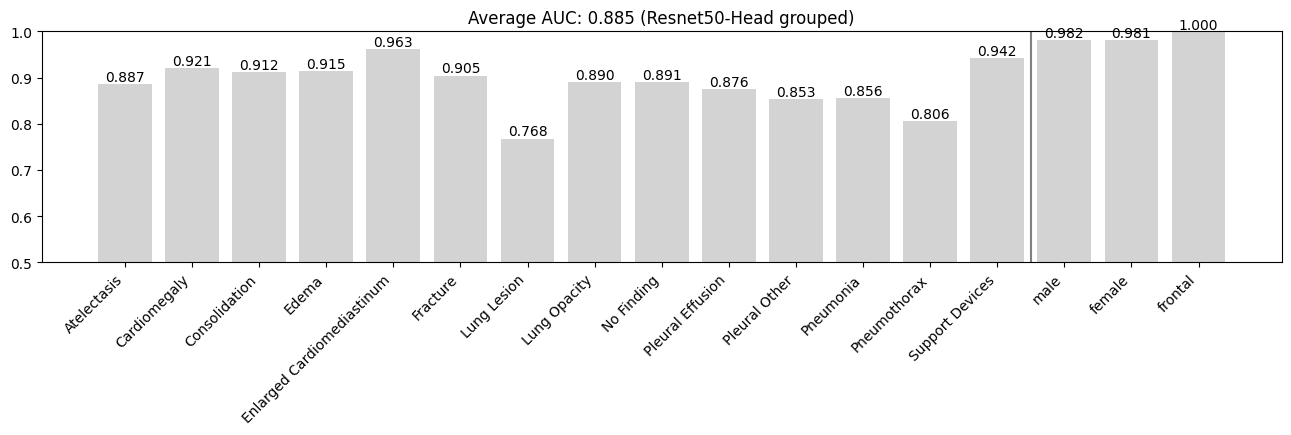

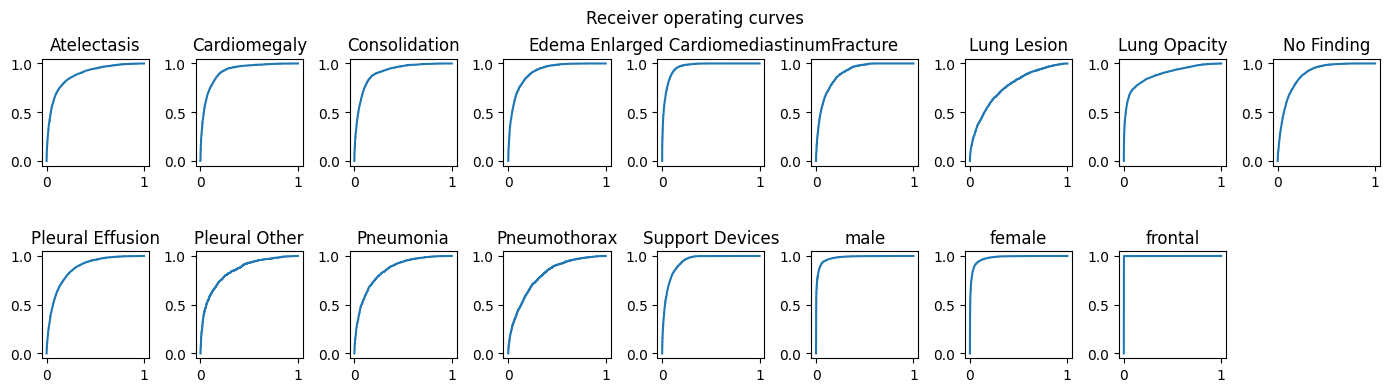

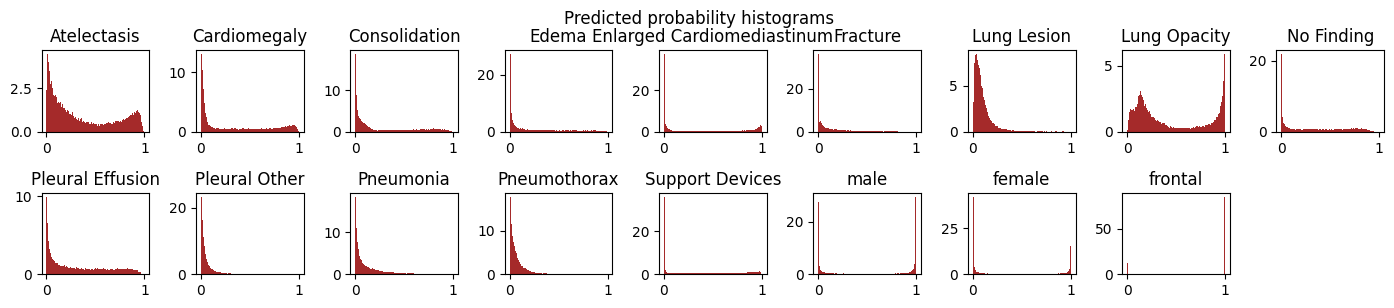

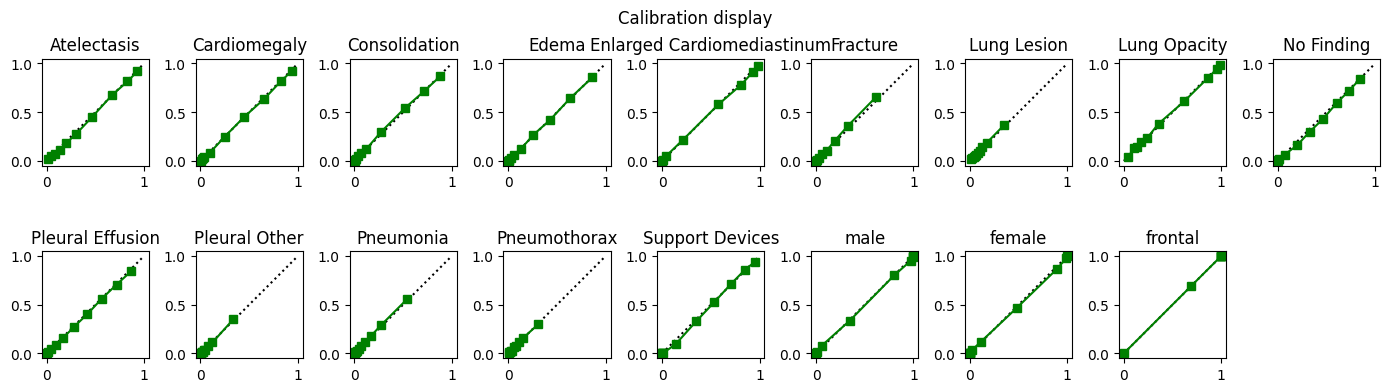


723/723 - 3s - 4ms/step
Fitting Resnet50-Head
Epoch 1/50
1343/1343 - 21s - 16ms/step - AUC: 0.8358 - loss: 0.3384 - val_AUC: 0.8565 - val_loss: 0.3114 - learning_rate: 0.0010
Epoch 2/50
1343/1343 - 17s - 13ms/step - AUC: 0.8559 - loss: 0.3106 - val_AUC: 0.8633 - val_loss: 0.2999 - learning_rate: 0.0010
Epoch 3/50
1343/1343 - 17s - 13ms/step - AUC: 0.8629 - loss: 0.3009 - val_AUC: 0.8672 - val_loss: 0.2935 - learning_rate: 0.0010
Epoch 4/50
1343/1343 - 17s - 13ms/step - AUC: 0.8674 - loss: 0.2952 - val_AUC: 0.8683 - val_loss: 0.2924 - learning_rate: 0.0010
Epoch 5/50
1343/1343 - 17s - 13ms/step - AUC: 0.8707 - loss: 0.2907 - val_AUC: 0.8707 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 6/50
1343/1343 - 17s - 13ms/step - AUC: 0.8735 - loss: 0.2873 - val_AUC: 0.8734 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1343/1343 - 17s - 13ms/step - AUC: 0.8750 - loss: 0.2853 - val_AUC: 0.8730 - val_loss: 0.28

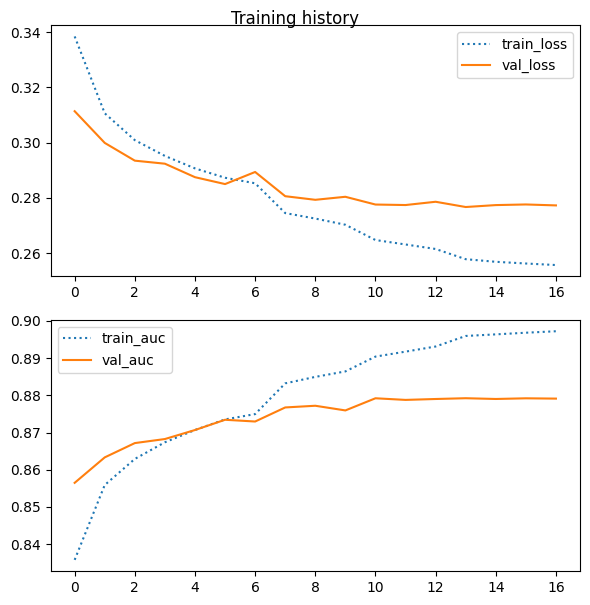


Validation
336/336 - 1s - 4ms/step
Resnet50-Head	0.879	0.884	0.919	0.916	0.916	0.965	0.898	0.741	0.891	0.881	0.872	0.834	0.851	0.804	0.936	0.983	0.982	0.999
Resnet50-Head grouped	0.883	0.887	0.921	0.919	0.919	0.967	0.902	0.746	0.894	0.885	0.877	0.842	0.857	0.809	0.938	0.984	0.982	0.999


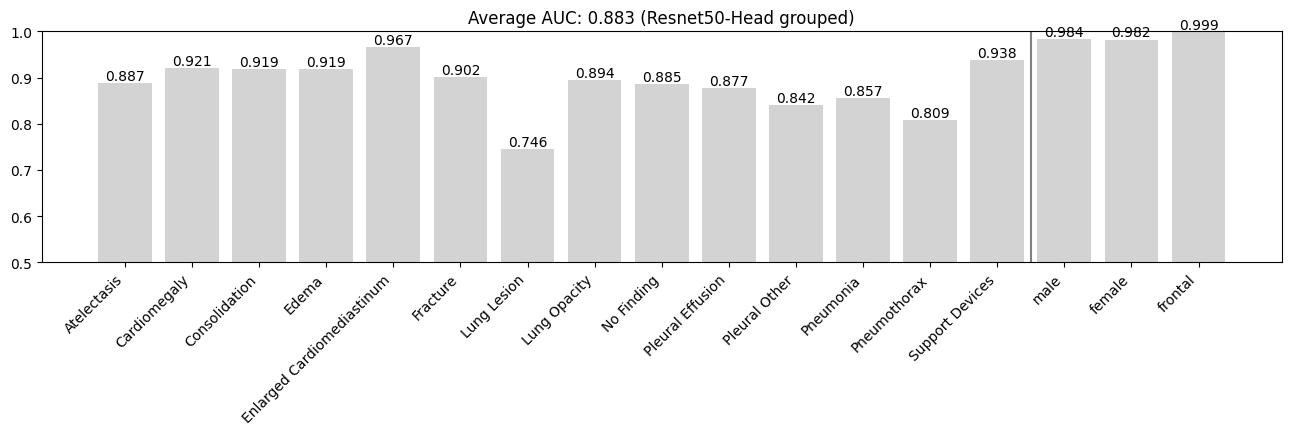

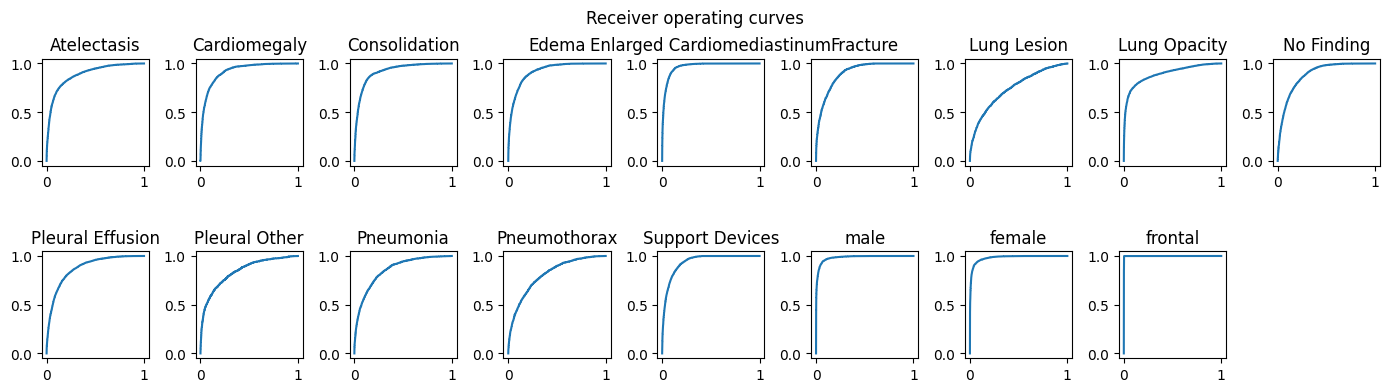

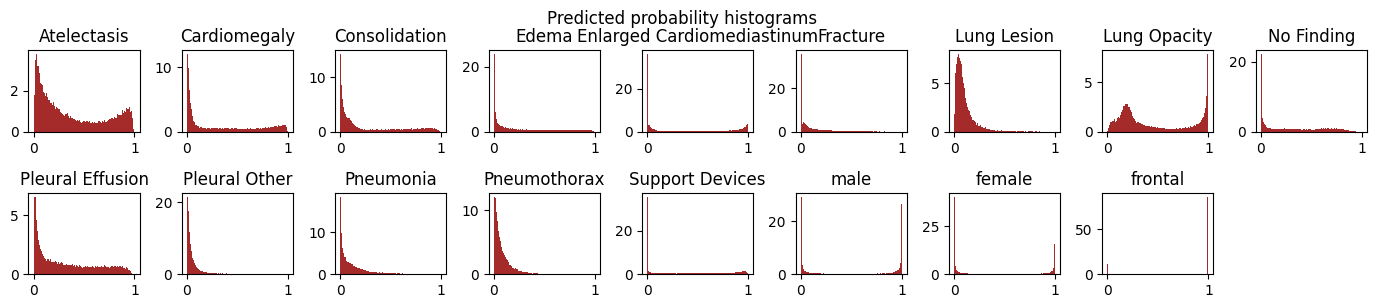

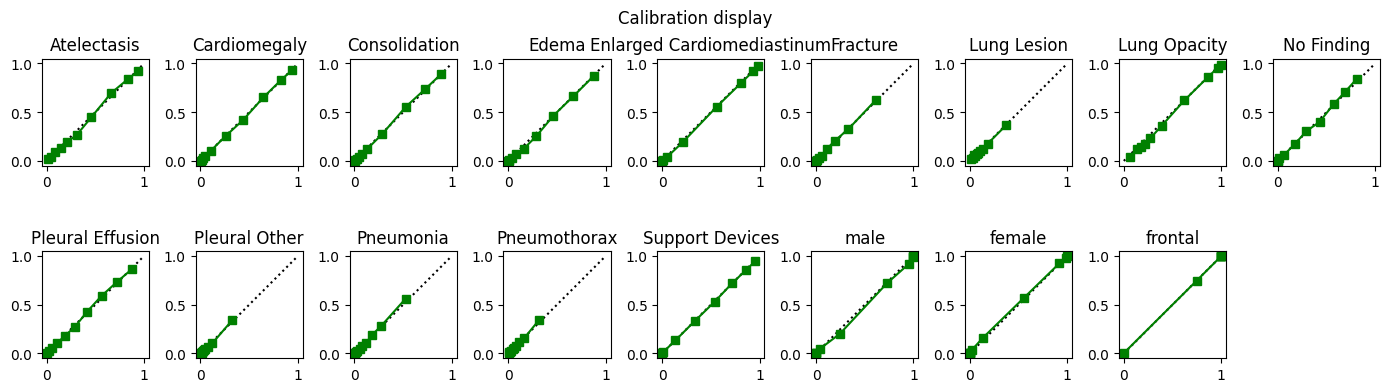


723/723 - 3s - 4ms/step


In [9]:
# %%time

# Parameters
epochs, n_folds, compute_test_predictions = 50, 5, True # for submission
# epochs, n_folds, compute_test_predictions = 50, 1, False # for validation without submission
batch_size = 64
verbose = 1 if os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive' else 2

if compute_test_predictions:
    test_generator = XRayGeneratorForResNet(test, None, embeddings_test, batch_size=batch_size, shuffle=False)
    test_pred_list = []

gkf = GroupKFold()
for fold, (idx_tr, idx_va) in enumerate(gkf.split(train, groups=train.Patient_ID)):
    if fold == n_folds: break

    # Split into train and test and construct the generators
    X_tr = train.iloc[idx_tr]
    X_va = train.iloc[idx_va]
    y_tr = y_train.iloc[idx_tr]
    y_va = y_train.iloc[idx_va]
    train_generator = XRayGeneratorForResNet(X_tr, y_tr, embeddings_train, batch_size=batch_size, shuffle=True)
    val_generator = XRayGeneratorForResNet(X_va, y_va, embeddings_train, batch_size=batch_size, shuffle=False)
    
    # Construct and compile the model
    model = create_head_model()
    label = f"{model.name}"
    print('Fitting', label)
    label_weights = (y_train.var(axis=0) != 0).astype(float) # exclude constant targets from metric
    label_weights[14:] = 0 # exclude just-for-fun targets from metric
    model.compile(
        # optimizer=Adam(learning_rate=0.001),
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[AUC(multi_label=True, name='AUC', label_weights=label_weights)]
    )
    
    # Train and plot the training history
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[EarlyStopping(patience=3),
                   ReduceLROnPlateau(factor=0.5, patience=0, verbose=1, min_lr=0.000126),
                   TerminateOnNaN()],
        verbose=verbose
    )
    history = history.history
    plot_training_history(history)

    def do_inference(generator, X, y_true=None):
        """Compute predictions grouping by study, and evaluate them."""
        y_pred = model.predict(generator, verbose=verbose)
        if y_true is not None: evaluate_oof(y_true, y_pred, label=label, plot=False)
        
        y_pred_frontal = y_pred[:,-1]
        y_pred = pd.DataFrame(y_pred, index=X.index)
        y_pred = y_pred.groupby(X['Patient_Study'].values).transform(lambda x: x.values.mean()).values
        y_pred[:,-1] = y_pred_frontal
        if y_true is not None: evaluate_oof(y_true, y_pred, label=label+' grouped')
        return y_pred

    # Validate and visualize validation score
    print("\nValidation")
    do_inference(val_generator, X_va, y_va)
    print()

    # Compute test_predictions
    if compute_test_predictions:
        test_pred_list.append(do_inference(test_generator, test))


# Submission

As we have trained five models for cross-validation, we can now compute the submission as an ensemble of the predictions of five models.

In [10]:
if len(test_pred_list) > 0:
    test_pred = np.stack(test_pred_list).mean(axis=0)
    submission = pd.DataFrame(test_pred[:,:14],
                              columns=targets,
                              index=test.Image_name)
    display(submission)
    submission.to_csv('submission.csv')
    !head submission.csv


,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
Image_name,,,,,,,,,,,,,,
00000005_001_001.jpg,0.023799,0.013376,0.016379,0.005612,2.140917e-02,6.673741e-02,0.037387,0.037870,0.714168,0.021050,0.048666,0.030893,0.023627,2.134462e-01
00000005_001_002.jpg,0.023799,0.013376,0.016379,0.005612,2.140917e-02,6.673741e-02,0.037387,0.037870,0.714168,0.021050,0.048666,0.030893,0.023627,2.134462e-01
00000005_002_001.jpg,0.670272,0.375347,0.437771,0.151537,5.446376e-01,4.585125e-01,0.066597,0.687024,0.081838,0.523353,0.114260,0.214633,0.328699,7.012467e-01
00000005_002_002.jpg,0.670272,0.375347,0.437771,0.151537,5.446376e-01,4.585125e-01,0.066597,0.687024,0.081838,0.523353,0.114260,0.214633,0.328699,7.012467e-01
00000007_001_001.jpg,0.720479,0.724762,0.527500,0.500813,8.513462e-01,2.958631e-01,0.090075,0.857677,0.029347,0.588970,0.096907,0.203723,0.099473,6.685597e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20009235_000_000.jpg,0.152364,0.020214,0.019876,0.003862,4.603379e-07,3.637827e-07,0.093903,0.135606,0.652988,0.057107,0.024275,0.006975,0.013251,2.789012e-07
20009236_000_000.jpg,0.036725,0.009521,0.008086,0.002411,2.161949e-07,3.910168e-07,0.078242,0.113349,0.782346,0.011013,0.013376,0.004857,0.004235,7.589782e-08
20009238_000_000.jpg,0.023445,0.009082,0.005139,0.000762,1.643777e-06,7.301628e-06,0.064590,0.123565,0.785486,0.009169,0.018670,0.004776,0.004014,7.177802e-07


Image_name,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
00000005_001_001.jpg,0.02379936,0.013375777,0.016379066,0.0056123217,0.021409174,0.06673741,0.037386674,0.037869744,0.7141685,0.021049568,0.04866631,0.030892724,0.023627315,0.21344618
00000005_001_002.jpg,0.02379936,0.013375777,0.016379066,0.0056123217,0.021409174,0.06673741,0.037386674,0.037869744,0.7141685,0.021049568,0.04866631,0.030892724,0.023627315,0.21344618
00000005_002_001.jpg,0.67027235,0.37534708,0.43777075,0.151537,0.54463756,0.45851254,0.06659691,0.68702424,0.081837565,0.52335346,0.11425984,0.2146326,0.32869878,0.7012467
00000005_002_002.jpg,0.67027235,0.37534708,0.43777075,0.151537,0.54463756,0.45851254,0.06659691,0.68702424,0.081837565,0.52335346,0.11425984,0.2146326,0.32869878,0.7012467
00000007_001_001.jpg,0.7204794,0.72476184,0.5275004,0.50081265,0.8513462,0.2958631,0.09007